# CNN for Image Classifcation

Now that we got familiar with the architecture of a CNN:

Input -> Convolutional Layer -> Max Pooling Layer -> Fully Connected Layer -> Output

![q](cnn_img/q34.png)

We must also discuss a couple of things in preprocessing:

1. Image resizing
2. Converting to Tensor
3. Normalization


Convolutional Layers should be used to decrease in used to increase the depth at which the model sees features. Max pooling layers should be used filter out the useless features of each map by reducing the 2-D size. As we get deeper the network is able to pick up feautures it needs to distinguish which class the input is.

## Padding Revisited

Padding is just adding a border of pixels around an image. In PyTorch, you specify the size of this border.

Why do we need padding?

When we create a convolutional layer, we move a square filter around an image, using a center-pixel as an anchor. So, this kernel cannot perfectly overlay the edges/corners of images. The nice feature of padding is that it will allow us to control the spatial size of the output volumes (most commonly as we’ll see soon we will use it to exactly preserve the spatial size of the input volume so the input and output width and height are the same).

The most common methods of padding are padding an image with all 0-pixels (zero padding) or padding them with the nearest pixel value.
You can read more about calculating the amount of padding, given a kernel_size, [here](https://cs231n.github.io/convolutional-networks/#conv).

# How to Define a Conv Layer in PyTorch

![q](cnn_img/q35.png)

```python

self.conv1 = nn.Conv2d(3, 16, kernel_size = (3,3), stride=1, padding=1)
# nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)

```

![q](cnn_img/q36.png)


# How to Define a Max Pooling Layer in PyTorch

```python

self.maxpool = nn.MaxPool(2,2) #(size, stride)

```

# Arguments
You must pass the following arguments:

1. in_channels - The number of inputs (in depth), 3 for an RGB image, for example.
2. out_channels - The number of output channels, i.e. the number of filtered "images" a convolutional layer is made of or the number of unique, convolutional kernels that will be applied to an input.
3. kernel_size - Number specifying both the height and width of the (square) convolutional kernel.

There are some additional, optional arguments that you might like to tune:

4. stride - The stride of the convolution. If you don't specify anything, stride is set to 1.
5. padding - The border of 0's around an input array. If you don't specify anything, padding is set to 0.

Convolution with 3x3 window and stride of 1 , padding of 0:

![q](cnn_img/1.gif)

# Sequential Models
We can also create a CNN in PyTorch by using a Sequential wrapper in the __init__ function. Sequential allows us to stack different types of layers, specifying activation functions in between!

```python

def __init__(self):
        super(ModelName, self).__init__()
        self.features = nn.Sequential(
              nn.Conv2d(1, 16, 2, stride=2),
              nn.MaxPool2d(2, 2),
              nn.ReLU(True),

              nn.Conv2d(16, 32, 3, padding=1),
              nn.MaxPool2d(2, 2),
              nn.ReLU(True) 
         )

```

# Flattening

It is important to understand how the feature maps take shape after being passed through several layers. For eg what is the dimension of the feature map after being passed through these layers:

Inital image dim: 130x130

```python
nn.Conv2d(3, 10, 3)
nn.MaxPool2d(4, 4)
nn.Conv2d(10, 20, 5, padding=2)
nn.MaxPool2d(2, 2)
```

Ans: 30x30

Why? The 130x130 image shrinks by a size of a one-pixel border to becomes 128x128 after the first convolutional layer due to 3x3 kernal with no padding. Then that is down-sampled by 4 (128/4 = 32). The next conv layer supports a 5x5 kernal because of a padding of 2. then 2 (32/2 = 16) after each successive maxpooling layer!

How many Parameters are resulting?

Ans: 16x16x20

Remember: As the depth increases in convolutional layers: 3 ->10 -> 20 , the depth at which our filters execute also change. So in Conv2d , we use 20 filters with a dimensionality of: 32x32x10 to apply to our images coming in from nn.Pool2d

# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='cnn_img/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
# imports
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

print(train_on_gpu)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

True
CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [2]:
# number of subprocesses
num_workers = 0
#batch size
batch_size = 32
# percentage of training set used as validation
valid_size = 0.2

#Conver to a tensor
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),
                                                  (0.5,0.5,0.5))])



train_data = datasets.CIFAR10('data', train=True, transform=transform, download=True)
test_data = datasets.CIFAR10('data', train=False, transform=transform, download=True)

# Obtain training indices that will be used for validation
num_train = len(train_data)
print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

Files already downloaded and verified
Files already downloaded and verified
50000


In [3]:
# Validating 
print(len(train_idx))
print(len(valid_idx))

40000
10000


In [4]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

### Visualize a Batch of Training Data

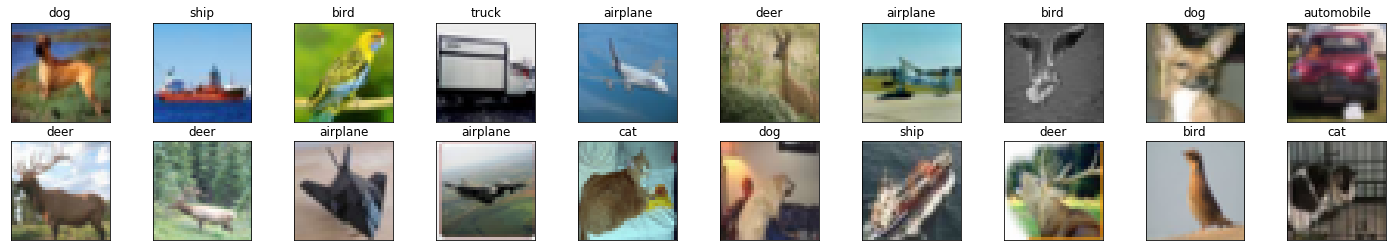

In [5]:
# Helper function to visualize 
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

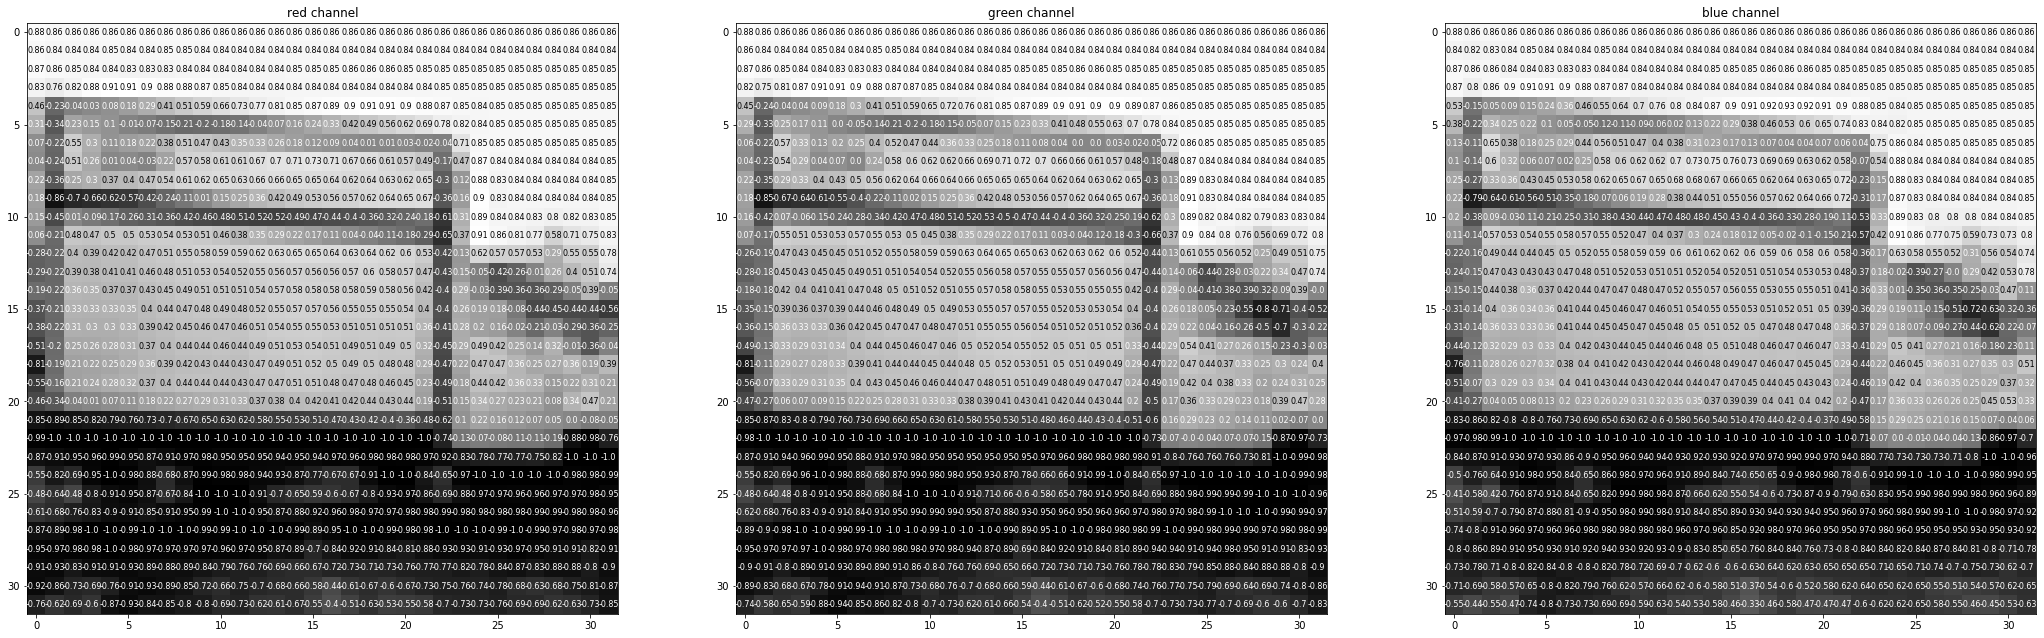

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='cnn_img/2_layer_conv.png' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward network behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 4x4x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        # linear layer (512 -> 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 128 * 2 * 2)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc3(x)
        return x


In [36]:
model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

Define the loss and optimizer and see how these choices change the loss over time.

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [43]:
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs +1):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # Train Mode
    
    for data, target in train_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad() # Reset Gradient
        output = model(data) # Foward Pass
        loss = criterion(output, target) # # calculate the batch loss
        loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # perform a single optimization step (parameter update)
        train_loss += loss.item()*data.size(0) # update training loss
        
    ######################    
    # validate the model #
    ######################            
    
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(output, target) # calculate the batch loss
        valid_loss += loss.item()*data.size(0) # update average validation loss 
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.600547 	Validation Loss: 0.379378
Validation loss decreased (inf --> 0.379378).  Saving model ...
Epoch: 2 	Training Loss: 1.463510 	Validation Loss: 0.342544
Validation loss decreased (0.379378 --> 0.342544).  Saving model ...
Epoch: 3 	Training Loss: 1.373734 	Validation Loss: 0.326000
Validation loss decreased (0.342544 --> 0.326000).  Saving model ...
Epoch: 4 	Training Loss: 1.295519 	Validation Loss: 0.312465
Validation loss decreased (0.326000 --> 0.312465).  Saving model ...
Epoch: 5 	Training Loss: 1.226164 	Validation Loss: 0.291167
Validation loss decreased (0.312465 --> 0.291167).  Saving model ...
Epoch: 6 	Training Loss: 1.161280 	Validation Loss: 0.275100
Validation loss decreased (0.291167 --> 0.275100).  Saving model ...
Epoch: 7 	Training Loss: 1.109301 	Validation Loss: 0.262234
Validation loss decreased (0.275100 --> 0.262234).  Saving model ...
Epoch: 8 	Training Loss: 1.064406 	Validation Loss: 0.260153
Validation loss decreased (0.26223

In [44]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

# Test the Trained Network
Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [46]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.777878

Test Accuracy of airplane: 78% (782/1000)
Test Accuracy of automobile: 88% (884/1000)
Test Accuracy of  bird: 57% (570/1000)
Test Accuracy of   cat: 59% (594/1000)
Test Accuracy of  deer: 65% (650/1000)
Test Accuracy of   dog: 65% (650/1000)
Test Accuracy of  frog: 82% (822/1000)
Test Accuracy of horse: 76% (761/1000)
Test Accuracy of  ship: 85% (852/1000)
Test Accuracy of truck: 76% (767/1000)

Test Accuracy (Overall): 73% (7332/10000)


## Question: What are your model's weaknesses and how might they be improved?

Answer: This model seems to do best on vehicles rather than animals. For example, it does best on the automobile class and worst on the cat class. I suspect it's because animals vary in color and size and so it would improve this model if I could increase the number of animal images in the first place or perhaps if I added another convolutional layer to detect finer patterns in these images. I could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.

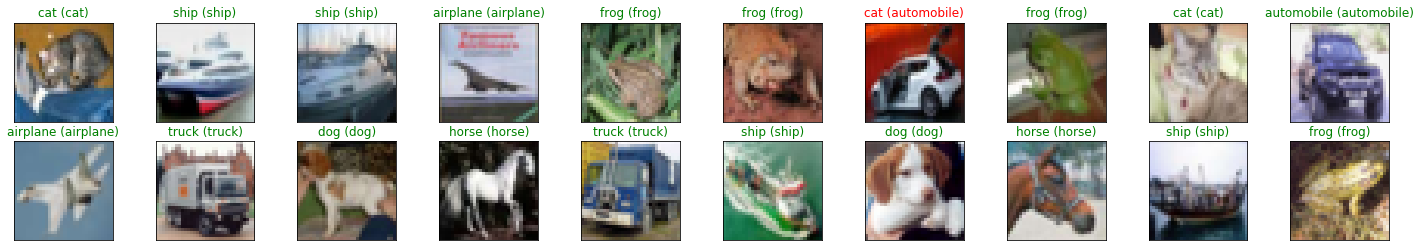

In [47]:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))